In [68]:
import pandas as pd

In [69]:
with open("data/softskills.txt") as file:
    softskills = [line.strip() for line in file.readlines()]

softskills_df = pd.DataFrame(softskills)
softskills_df

,0
0,Teamwork
1,Leadership
2,Resilience
3,Emotional Intelligence
4,Communication
5,Proactivity
6,Ethics
7,Complex Thinking


In [70]:
from data.operations_instances_ss_confirmed import fetch_operations_files, OperationFile

operations_files = fetch_operations_files()

In [71]:
from typing import List, Any, Tuple, Dict
import os
import json

OperationResults = Tuple[str, str, Dict[str, Any]]


def fetch_results(operation_file: "OperationFile", base_results_path: str = "results/openings_users/operations") -> List[OperationResults]:
    folder = os.path.join(base_results_path, operation_file.test_subpath)
    collected: List[OperationResults] = []

    for cluster_folder_name in os.listdir(folder):

        if cluster_folder_name in ["__pycache__", "__init__.py"]:
            continue

        cluster_folder_path = os.path.join(folder, cluster_folder_name)

        for result_name in os.listdir(cluster_folder_path):
            full_path = os.path.join(cluster_folder_path, result_name)

            with open(full_path, 'r') as file:
                json_results = json.load(file)

            collected.append((cluster_folder_name, full_path, json_results))

    return collected


In [72]:
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 5000)


In [73]:
from trigger.operation import read_operations

operations = read_operations(operations_files[0].full_path)

operations_df = pd.DataFrame([ { "type": operation.type, "info": operation.info } for operation in operations])
operations_df

,type,info
0,OperationType.ADD,"AddInfo(tag='0', value=Instance(value=Opening(entityId='0', hardSkills=[Hardskill(name='UNIX'), Hardskill(name='React'), Hardskill(name='JavaScript'), Hardskill(name='Typescript'), Hardskill(name='Web'), Hardskill(name='Scraping'), Hardskill(name='Angular')], softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Communication'), Softskill(name='Teamwork')])), transformer_key='identity')"
1,OperationType.ADD,"AddInfo(tag='1', value=Instance(value=Opening(entityId='1', hardSkills=[Hardskill(name='Corporate Publications Corporate Relations')], softSkills=[Softskill(name='Leadership'), Softskill(name='Communication'), Softskill(name='Emotional Intelligence')])), transformer_key='identity')"
2,OperationType.ADD,"AddInfo(tag='5', value=Instance(value=Opening(entityId='5', hardSkills=[Hardskill(name='Word Processing'), Hardskill(name='Contract Negotiation'), Hardskill(name='Office Management Policies and Procedures')], softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Leadership'), Softskill(name='Communication')])), transformer_key='identity')"
3,OperationType.ADD,"AddInfo(tag='4', value=Instance(value=Opening(entityId='4', hardSkills=[Hardskill(name='Salary Administration Succession Planning'), Hardskill(name='Arbitration/Mediation')], softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Communication'), Softskill(name='Ethics')])), transformer_key='identity')"
4,OperationType.ADD,"AddInfo(tag='2', value=Instance(value=Opening(entityId='2', hardSkills=[Hardskill(name='Employment Ordinance'), Hardskill(name='Patents'), Hardskill(name='IPO Intellectual Property')], softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Leadership'), Softskill(name='Communication'), Softskill(name='Ethics')])), transformer_key='identity')"
5,OperationType.ADD,"AddInfo(tag='3', value=Instance(value=Opening(entityId='3', hardSkills=[Hardskill(name='Feasibility Studies Field Studies'), Hardskill(name='Lab Management'), Hardskill(name='RandD Management Simulation Dev.'), Hardskill(name='Patent Application'), Hardskill(name='Design and Specification'), Hardskill(name='Statistical Analysis')], softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Teamwork'), Softskill(name='Ethics')])), transformer_key='identity')"
6,OperationType.ADD,"AddInfo(tag='6', value=Instance(value=Opening(entityId='6', hardSkills=[Hardskill(name='Gastronomy')], softSkills=[Softskill(name='Leadership'), Softskill(name='Communication'), Softskill(name='Emotional Intelligence')])), transformer_key='identity')"
7,OperationType.EVALUATE_CLUSTERS,EvaluateClustersInfo()
8,OperationType.EVALUATE_MATCHES,"EvaluateMatchesInfo(values=[CalculateScoringInfo(value=Instance(value=User(name='Suzana', softSkills=[Softskill(name='Emotional Intelligence'), Softskill(name='Proactivity'), Softskill(name='Ethics')], hardSkills=[Hardskill(name='Human Resources Management Industrial Relations'), Hardskill(name='C+++')])), transformer_key='identity'), CalculateScoringInfo(value=Instance(value=User(name='Torrell', softSkills=[Softskill(name='Complex Thinking'), Softskill(name='Resilience'), Softskill(name='Communication'), Softskill(name='Leadership')], hardSkills=[Hardskill(name='Foreign Exchange')])), transformer_key='identity'), CalculateScoringInfo(value=Instance(value=User(name='Georgena', softSkills=[Softskill(name='Ethics'), Softskill(name='Communication'), Softskill(name='Emotional Intelligence')], hardSkills=[Hardskill(name='Employee Discipline')])), transformer_key='identity'), CalculateScoringInfo(value=Instance(value=User(name='Serafin', softSkills=[Softskill(name='Resilience'), Softskill(name='Communication'), Softskill(name='Emotional Intelligence')], hardSkills=[Hardskill(name='International Business Development International Expansion'), Hardskill(name='Marketing Plan'), Hardskill(name='Executive Recruiting Grievance Resolution')])), transformer_key='identity')])"


In [74]:
from trigger.test.trigger_test_runner import TriggerTestRunner


In [75]:
from interference.clusters.ecm import ECM


def with_ecm(operations_file: OperationFile):

    param_grid = {
        "distance_threshold": [0.001, 0.01, 0.1, 0.3, 0.5,
                               0.7, 0.9, 1, 1.2, 1.4, 1.5]
    }

    TriggerTestRunner(
        processor_class=ECM,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [76]:
from interference.clusters.gturbo import GTurbo


def with_gturbo(operations_file: OperationFile):

    param_grid = {
        "epsilon_b": [0.001, 0.01],
        "epsilon_n": [0],
        "lam": [200, 500],
        "beta": [0.9995],
        "alpha": [0.95],
        "max_age": [200, 500],
        "r0": [0.5, 1, 2.5, 5, 8]
    }

    if operations_file.layer.find("concat") != -1:
        param_grid["dimensions"] = [2048]
    else:
        param_grid["dimensions"] = [1024]

    TriggerTestRunner(
        processor_class=GTurbo,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [77]:
from interference.clusters.fake import Fake


def with_fake(operations_file: OperationFile):

    param_grid = {
    }

    TriggerTestRunner(
        processor_class=Fake,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [78]:
from interference.clusters.covariance import CovarianceCluster


def with_covariance(operations_file: OperationFile):

    param_grid = {
        "initial_std": [10],
    }

    if operations_file.layer.find("concat") != -1:
        param_grid["dimensions"] = [2048]
    else:
        param_grid["dimensions"] = [1024]

    TriggerTestRunner(
        processor_class=CovarianceCluster,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

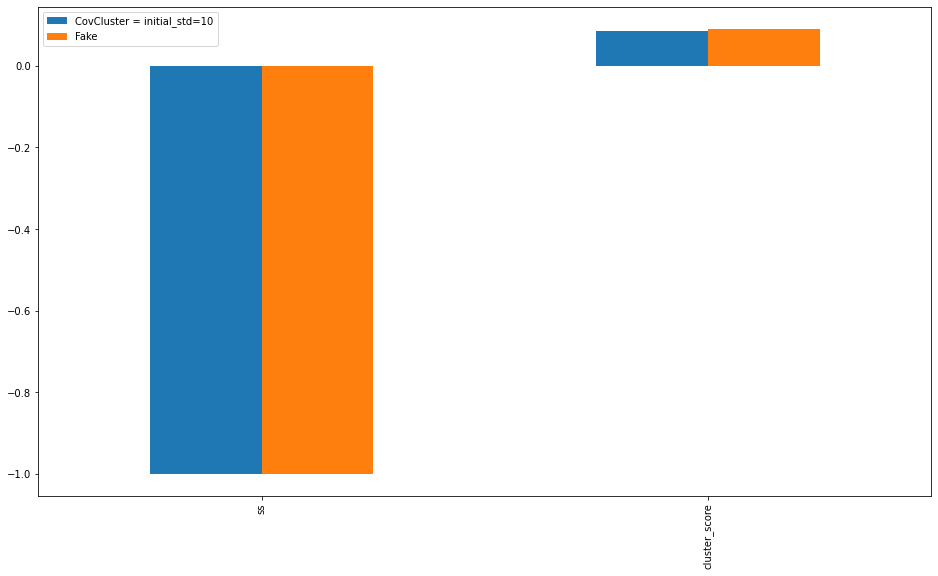

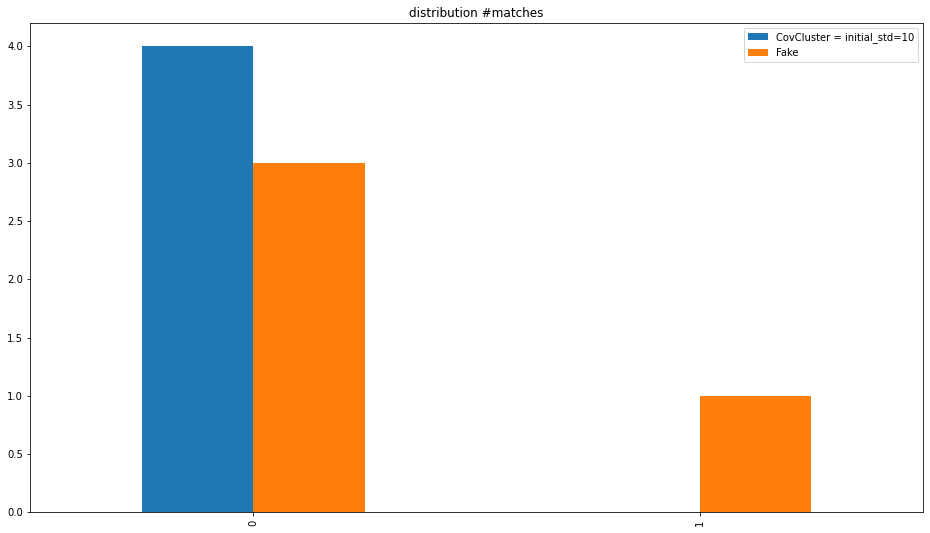

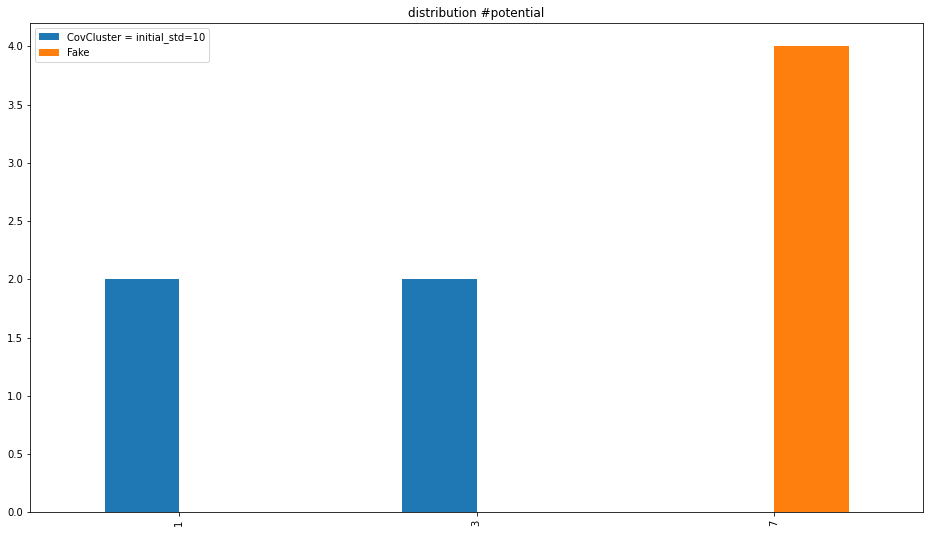

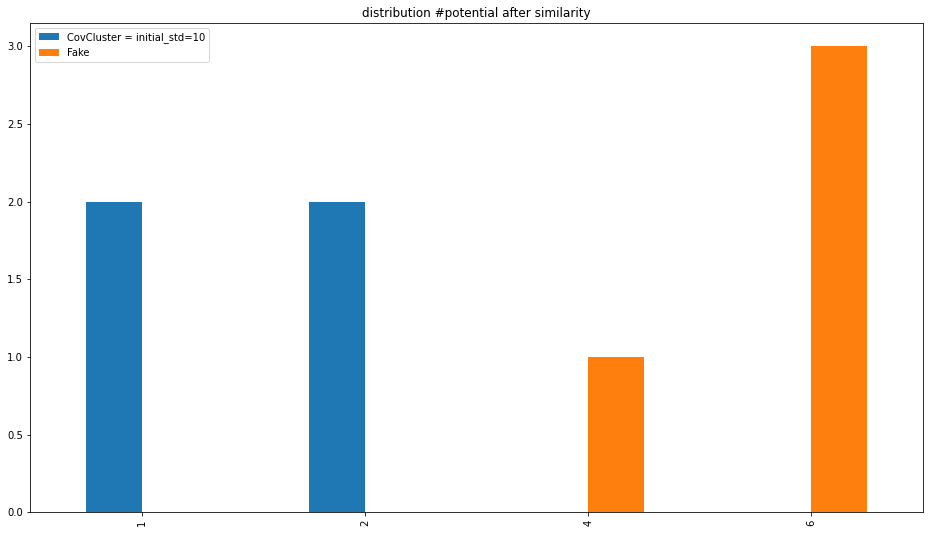

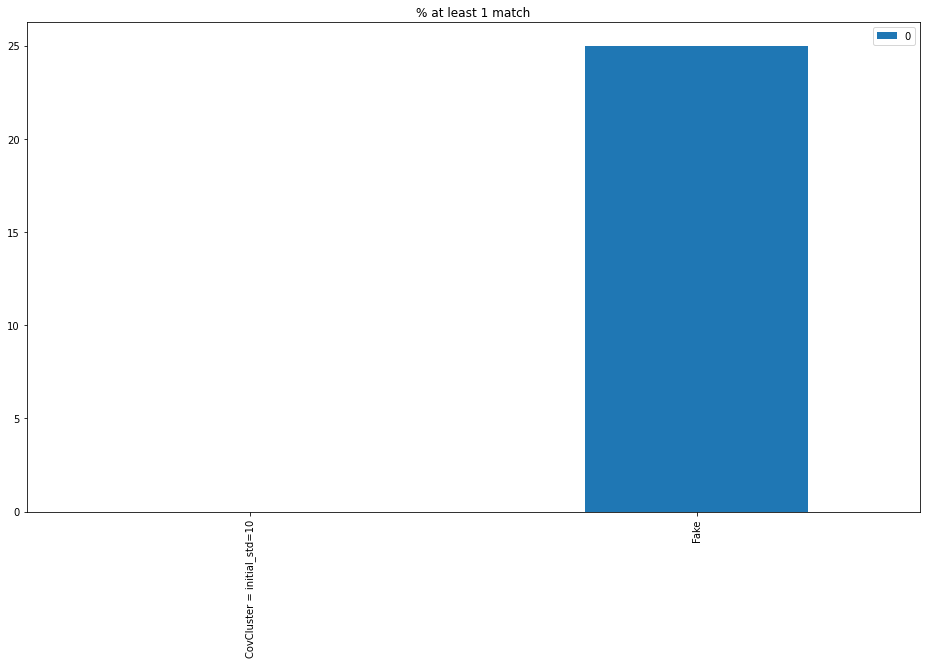

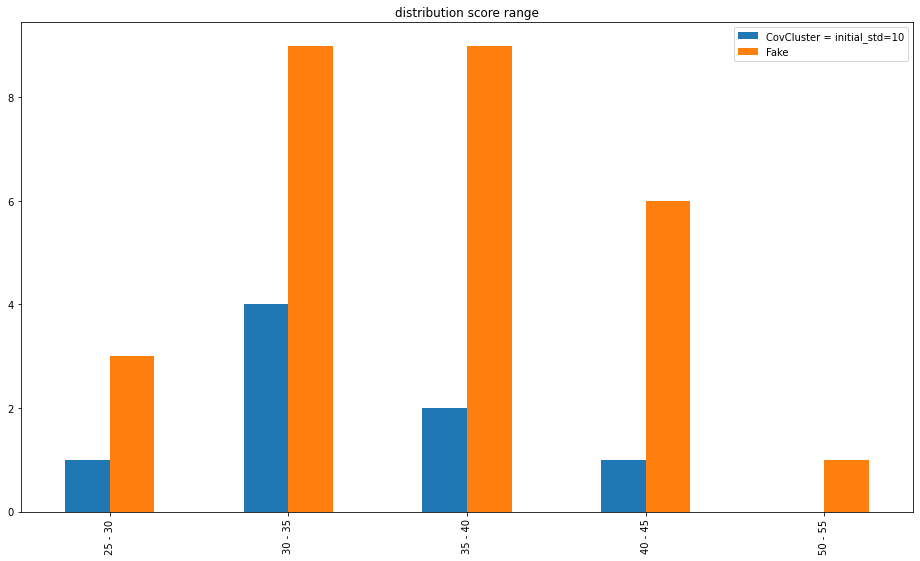

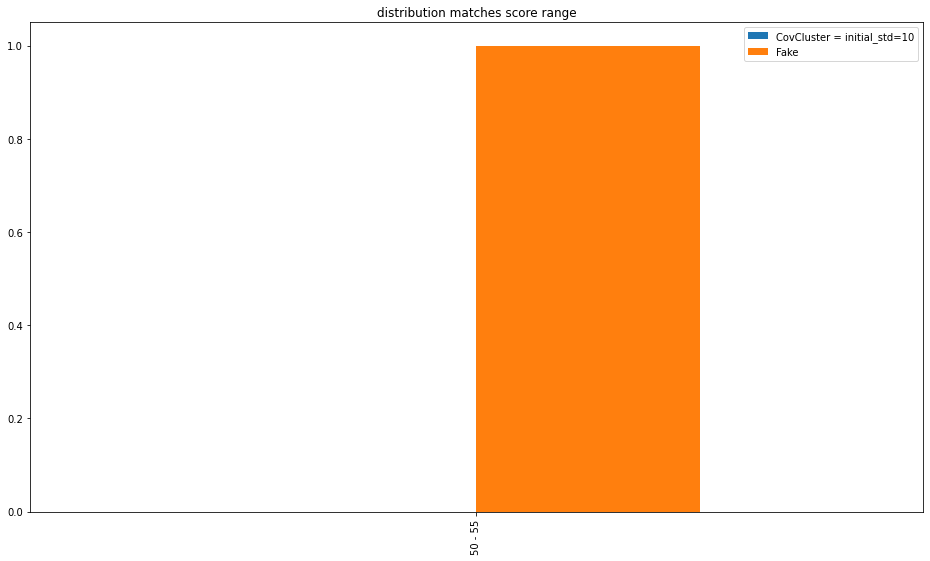

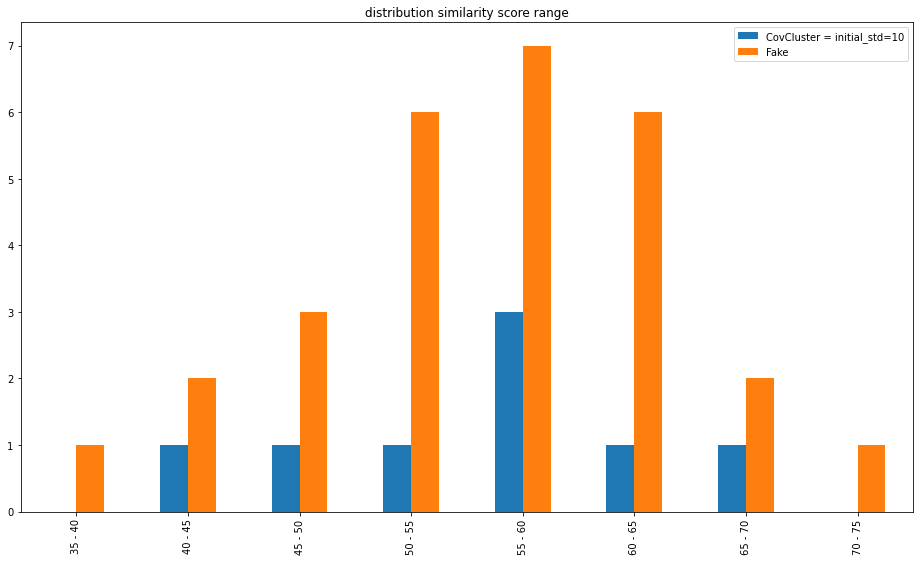

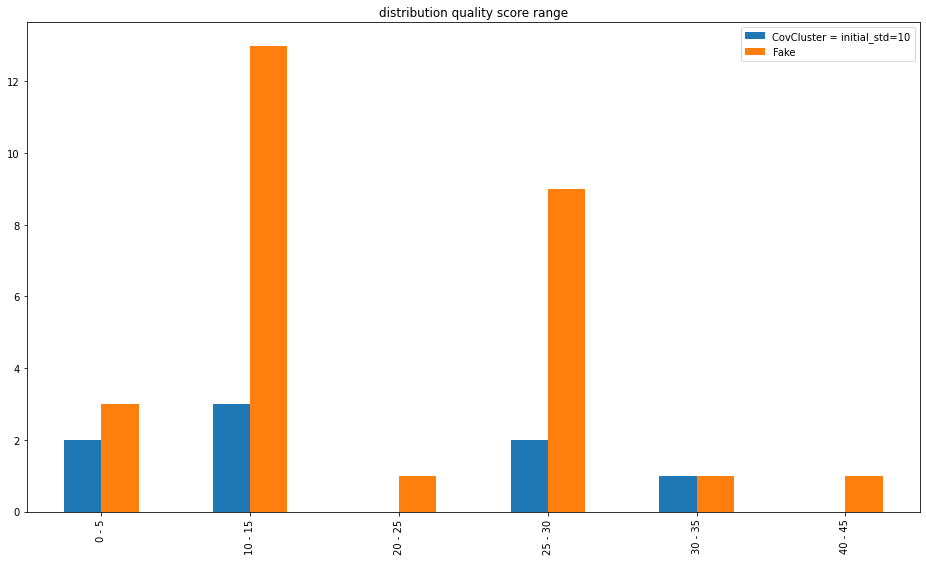

In [83]:
import logging
logging.getLogger("test_runner").setLevel(logging.WARNING)

from pathlib import Path

def distribution_with_zeros(before: dict, fake_dict: dict) -> dict:
    for _value in fake_dict:
        if _value not in before:
            before[_value] = 0
        
    return before

def distribution_key_ordered(before: dict) -> dict:
    after = {}
    for _value in sorted(before):
        after[_value] = before[_value]
    return after


for operations_file in operations_files[:1]:
    #print(operations_file)

    with_ecm(operations_file)
    with_gturbo(operations_file)
    with_covariance(operations_file)
    with_fake(operations_file)

    results = fetch_results(operations_file)

    cluster_metrics = [("ss", -2., 1), ("cluster_score", 0., 1.)]
    matches_metrics = [
        "distribution #matches",
        "distribution #potential",
        "distribution #potential after similarity", 
        '% at least 1 match',
        "distribution score range",
        "distribution matches score range",
        "distribution similarity score range",
        "distribution quality score range"
    ]

    name_to_cluster_metrics = {}
    name_to_matches_metrics = {}

    for clusterer, path, jsons in results:
        clusterer_description = Path(path).name.replace(".json", "")

        operation_results = jsons["results"]
        cluster_evaluation = operation_results[0]["Result"]

        continue_this_clusterer = True

        for cluster_metric, _min, _max in cluster_metrics:
            cluster_metric_score = cluster_evaluation[cluster_metric]

            if clusterer_description == "Fake":
                name_to_cluster_metrics.setdefault(clusterer_description, {})
                name_to_cluster_metrics["Fake"][cluster_metric] = cluster_metric_score

            elif _max > cluster_metric_score > _min:
                name_to_cluster_metrics.setdefault(clusterer_description, {})
                name_to_cluster_metrics[clusterer_description][cluster_metric] = cluster_metric_score

            else:
                del name_to_cluster_metrics[clusterer_description]
                continue_this_clusterer = False
                break

        if not continue_this_clusterer:
            continue

        matches_evaluation = operation_results[1]["Result"]

        for matches_metric in matches_metrics:
            name_to_matches_metrics.setdefault(clusterer_description, {})
            name_to_matches_metrics[clusterer_description][matches_metric] = matches_evaluation[matches_metric]

    for matches_metric in matches_metrics:
        if matches_metric.find("distribution") != -1:
            for name in name_to_matches_metrics:
                if name == "Fake":
                    continue
                
                name_to_matches_metrics["Fake"][matches_metric] = distribution_key_ordered(name_to_matches_metrics["Fake"][matches_metric])

                name_to_matches_metrics[name][matches_metric] = distribution_with_zeros(
                    name_to_matches_metrics[name][matches_metric],
                    name_to_matches_metrics["Fake"][matches_metric]
                )

                name_to_matches_metrics[name][matches_metric] = distribution_key_ordered(name_to_matches_metrics[name][matches_metric])


    name_to_cluster_metrics_df = pd.DataFrame.from_dict(name_to_cluster_metrics)
    name_to_cluster_metrics_df.plot(kind='bar', figsize=(16,9))

    for matches_metric in matches_metrics:
        t = {}
        for name in name_to_matches_metrics:
            t[name] = name_to_matches_metrics[name][matches_metric]

        if matches_metric.find("distribution") != -1:
            matches_metric_df = pd.DataFrame.from_dict(t)
            plot = matches_metric_df.plot(kind='bar', figsize=(16,9))
            plot.set_title(matches_metric)

        else:
            matches_metric_df = pd.DataFrame.from_dict(t, orient = 'index')
            plot = matches_metric_df.plot(kind='bar', figsize=(16,9))
            plot.set_title(matches_metric)
